In [7]:

# Imports
import os
import shutil
from PIL import Image
import torch
import timm
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tkinter import Tk, filedialog


In [8]:

# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [9]:

# 2. Paths and Constants
data_dir = 'C:/Users/hp/Downloads/Snake_Dataset1/Snake_Dataset'
split_dir = 'C:/Users/hp/Downloads/Snake_Dataset1/Split_Snake_Dataset'
train_ratio = 0.85
img_size = 384
batch_size = 8
num_epochs = 15


In [10]:

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

inference_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [11]:

# 4. Split Dataset if Needed
if not os.path.exists(split_dir):
    print('Splitting dataset...')
    os.makedirs(os.path.join(split_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'val'), exist_ok=True)
    full = ImageFolder(data_dir)
    classes = full.classes
    samples = full.samples
    # Map class to image paths
    cls_to_paths = {cls: [] for cls in classes}
    for path, label in samples:
        cls_to_paths[classes[label]].append(path)
    # Copy files
    for cls, paths in cls_to_paths.items():
        train_count = int(len(paths)*train_ratio)
        for i, p in enumerate(paths):
            dest = 'train' if i<train_count else 'val'
            out_dir = os.path.join(split_dir, dest, cls)
            os.makedirs(out_dir, exist_ok=True)
            shutil.copy(p, out_dir)
else:
    print('Dataset already split.')


Splitting dataset...


In [12]:

# 5. Load Datasets & Dataloaders
train_ds = ImageFolder(os.path.join(split_dir,'train'), transform=train_transform)
val_ds = ImageFolder(os.path.join(split_dir,'val'), transform=train_transform)
classes = train_ds.classes
num_classes = len(classes)

print(f'Classes ({num_classes}):', classes)

dl_train = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Classes (26): ['Ahaetulla_nasuta', 'Amphiesma_stolatum', 'Boiga_ochracea', 'Boiga_trigonata', 'Bungarus_caeruleus', 'Bungarus_fasciatus', 'Calliophis_bivirgatus', 'Coelongnathus_radiatus', 'Craspedocephalus_albolabris', 'Daboia_russelii', 'Dendrelaphis_tristis', 'Eryx_johnii', 'Gloydius_himalayanus', 'Indotyphlops_braminus', 'Lycodon_aulicus', 'Naja_kaouthia', 'Naja_naja', 'Oligodon_arnensis', 'Ophiophagus_hannah', 'Oreocryptophis_porphyraceus', 'Ovophis_monticola', 'Pytas_mucosa', 'Python_molurus', 'Rhabdophis_subminiatus', 'Sibynophis_subpunctatus', 'Xenochrophis_piscator']


In [13]:

# 6. Create Model
model = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=True, num_classes=num_classes)
model.to(device)


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--timm--tf_efficientnetv2_s.in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [14]:

# 7. Loss, Optimizer, Scheduler, AMP
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
scaler = GradScaler()


In [19]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(dl_train, desc=f'Epoch {epoch+1}/{num_epochs}'):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # ✅ Fixed autocast (no args)
        with autocast():
            outs = model(imgs)
            loss = criterion(outs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = outs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100

    # Validation
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dl_val:
            imgs, labels = imgs.to(device), labels.to(device)

            # ✅ Fixed autocast (no args)
            with autocast():
                outs = model(imgs)

            preds = outs.argmax(dim=1)
            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total * 100
    scheduler.step(epoch + val_acc)

    print(f'Epoch {epoch+1}: Train Loss {total_loss/len(dl_train):.4f}, Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%')
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientv2s.pth')
        print('✅ Saved Best Model')


C:\Users\hp\AppData\Local\Temp\ipykernel_7488\20351704.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|          | 0/1740 [00:00<?, ?it/s]C:\Users\hp\AppData\Local\Temp\ipykernel_7488\20351704.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15: 100%|██████████| 1740/1740 [05:01<00:00,  5.78it/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_7488\20351704.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 1.5239, Train Acc 72.10%, Val Acc 86.88%
✅ Saved Best Model


Epoch 2/15: 100%|██████████| 1740/1740 [05:39<00:00,  5.12it/s]


Epoch 2: Train Loss 1.0375, Train Acc 87.29%, Val Acc 88.54%
✅ Saved Best Model


Epoch 3/15: 100%|██████████| 1740/1740 [05:15<00:00,  5.51it/s]


Epoch 3: Train Loss 0.9445, Train Acc 90.29%, Val Acc 89.75%
✅ Saved Best Model


Epoch 4/15: 100%|██████████| 1740/1740 [05:17<00:00,  5.48it/s]


Epoch 4: Train Loss 0.8835, Train Acc 92.31%, Val Acc 91.25%
✅ Saved Best Model


Epoch 5/15: 100%|██████████| 1740/1740 [05:20<00:00,  5.44it/s]


Epoch 5: Train Loss 0.8415, Train Acc 93.53%, Val Acc 90.44%


Epoch 6/15: 100%|██████████| 1740/1740 [05:21<00:00,  5.41it/s]


Epoch 6: Train Loss 0.8077, Train Acc 94.63%, Val Acc 90.64%


Epoch 7/15: 100%|██████████| 1740/1740 [05:22<00:00,  5.40it/s]


Epoch 7: Train Loss 0.7745, Train Acc 95.87%, Val Acc 89.59%


Epoch 8/15: 100%|██████████| 1740/1740 [06:22<00:00,  4.55it/s]


Epoch 8: Train Loss 0.7780, Train Acc 95.22%, Val Acc 90.44%


Epoch 9/15: 100%|██████████| 1740/1740 [05:20<00:00,  5.43it/s]


Epoch 9: Train Loss 0.7510, Train Acc 96.44%, Val Acc 90.44%


Epoch 10/15: 100%|██████████| 1740/1740 [05:20<00:00,  5.42it/s]


Epoch 10: Train Loss 0.7373, Train Acc 96.86%, Val Acc 90.77%


Epoch 11/15: 100%|██████████| 1740/1740 [05:30<00:00,  5.26it/s]


Epoch 11: Train Loss 0.7252, Train Acc 97.14%, Val Acc 91.41%
✅ Saved Best Model


Epoch 12/15: 100%|██████████| 1740/1740 [05:24<00:00,  5.37it/s]


Epoch 12: Train Loss 0.7142, Train Acc 97.50%, Val Acc 90.64%


Epoch 13/15: 100%|██████████| 1740/1740 [05:23<00:00,  5.39it/s]


Epoch 13: Train Loss 0.7128, Train Acc 97.45%, Val Acc 90.08%


Epoch 14/15: 100%|██████████| 1740/1740 [05:39<00:00,  5.12it/s]


Epoch 14: Train Loss 0.7057, Train Acc 97.60%, Val Acc 91.66%
✅ Saved Best Model


Epoch 15/15: 100%|██████████| 1740/1740 [06:31<00:00,  4.45it/s]


Epoch 15: Train Loss 0.6968, Train Acc 98.01%, Val Acc 91.05%



Final Evaluation
                             precision    recall  f1-score   support

           Ahaetulla_nasuta       0.98      0.96      0.97        95
         Amphiesma_stolatum       0.89      0.92      0.90        97
             Boiga_ochracea       0.87      0.87      0.87        76
            Boiga_trigonata       0.80      0.99      0.89        98
         Bungarus_caeruleus       0.96      0.94      0.95        94
         Bungarus_fasciatus       0.99      0.96      0.97        97
      Calliophis_bivirgatus       1.00      0.98      0.99        94
     Coelongnathus_radiatus       0.98      0.91      0.95        94
Craspedocephalus_albolabris       0.95      0.96      0.96       100
            Daboia_russelii       0.96      0.97      0.96        95
       Dendrelaphis_tristis       0.83      0.93      0.88        90
                Eryx_johnii       0.89      0.89      0.89       105
       Gloydius_himalayanus       0.76      0.78      0.77        91
      Indotyphl

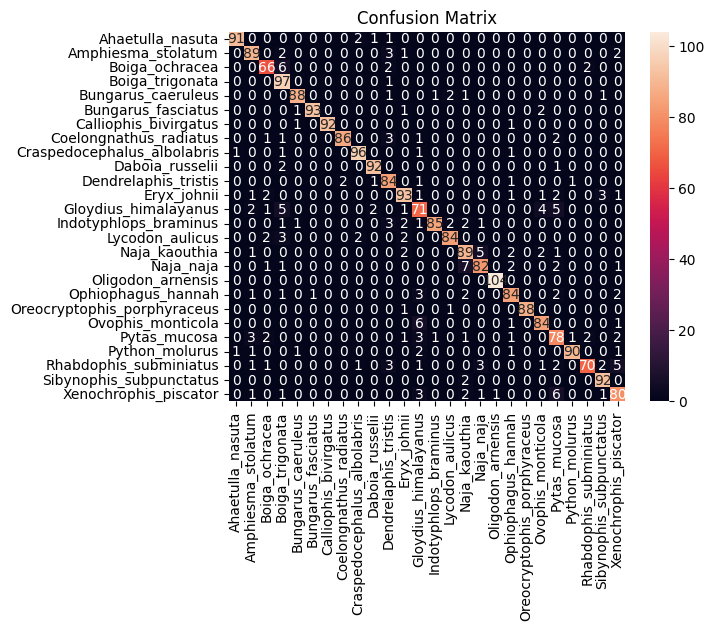

In [20]:

# 9. Final Evaluation
print('\nFinal Evaluation')
print(classification_report(all_labels, all_preds, target_names=classes))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.show()


In [27]:

# 10. Inference: Load Model & Predict
# File dialog
Tk().withdraw()
img_path = filedialog.askopenfilename(title='Select Snake Image')
if img_path:
    img = Image.open(img_path).convert('RGB')
    tensor = inference_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad(), autocast():
        out = model(tensor)
        probs = torch.softmax(out, dim=1)
        top3 = probs.topk(3)
    print('Top-3 Predictions:')
    for prob, idx in zip(top3.values[0], top3.indices[0]):
        print(f"{classes[idx]}: {prob.item()*100:.2f}%")



Top-3 Predictions:
Naja_kaouthia: 90.97%
Xenochrophis_piscator: 0.76%
Dendrelaphis_tristis: 0.61%


C:\Users\hp\AppData\Local\Temp\ipykernel_7488\3106262897.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
